# **Store Item Demand Forecasting Challenge**

**Import**

In [60]:
%pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.5 MB 388.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.5 MB 653.6 kB/s eta 0:00:03
   ----------- ---------------------------- 0.4/1.5 MB 2.2 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 3.2 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 4.0 MB/s eta 0:00:01
   -------------------------------------- - 1.4/1.5 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

from prophet import Prophet
import lightgbm as lgb

**Paths $ Params**

In [24]:
DATA_DIR = 'data' # put train.csv, test.csv, sample_submission.csv here
OUTPUT_DIR = 'output'
FORECAST_HORIZON = 90 # days (3 months ~ 90 days)
VAL_DAYS = 90
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('paths set')

paths set


**Load data**

In [32]:
train = pd.read_csv(('train.csv'), parse_dates=['date'])
test = pd.read_csv(('test.csv'), parse_dates=['date'])
sample_sub = pd.read_csv('sample_submission.csv')
print('train shape', train.shape)
print('test shape', test.shape)
print(train)
print(test)

train shape (913000, 4)
test shape (45000, 4)
             date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]
          id       date  store  item
0          0 2018-01-01      1     1
1          1 2018-01-02      1     1
2          2 2018-01-03      1     1
3          3 2018-01-04      1     1
4          4 2018-01-05      1     1
...      ...        ...    ...   ...
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50

[45000 rows x 4 columns]


          ds      y
0 2013-01-01  13696
1 2013-01-02  13678
2 2013-01-03  14488
3 2013-01-04  15677
4 2013-01-05  16237
date range: 2013-01-01 00:00:00 -> 2017-12-31 00:00:00


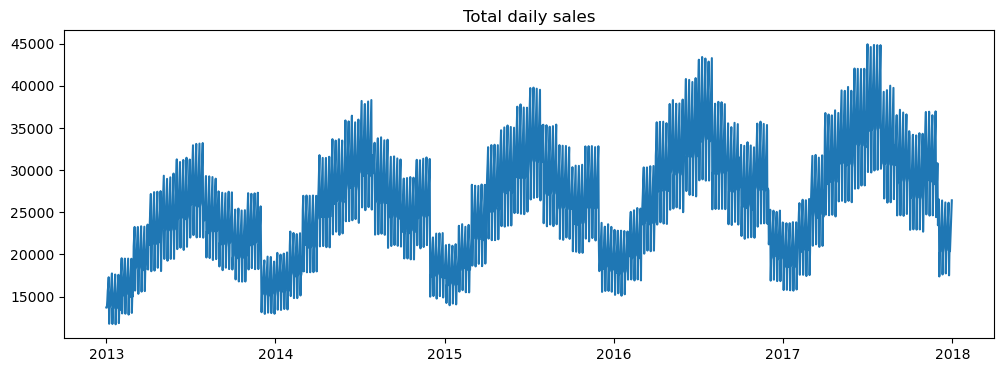

In [38]:
# Total daily sales across all store-item pairs
daily = train.groupby('date')['sales'].sum().reset_index().rename(columns={'date':'ds','sales':'y'})
print(daily.head())
print('date range:', daily['ds'].min(), '->', daily['ds'].max())

plt.figure(figsize=(12,4))
plt.plot(daily['ds'], daily['y'])
plt.title('Total daily sales')
plt.show()

In [40]:
daily = daily.sort_values('ds').reset_index(drop=True)
train_daily = daily.iloc[:-VAL_DAYS].reset_index(drop=True)
val_daily = daily.iloc[-VAL_DAYS:].reset_index(drop=True)
print('train_daily', train_daily.shape, 'val_daily', val_daily.shape)

train_daily (1736, 2) val_daily (90, 2)


In [49]:
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_daily.rename(columns={'ds':'ds','y':'y'}))
future = m.make_future_dataframe(periods=FORECAST_HORIZON)
forecast = m.predict(future)
forecast_small = forecast[['ds','yhat','yhat_lower','yhat_upper']]
# evaluate on validation dates
val_pred = forecast_small.set_index('ds').loc[val_daily['ds'], 'yhat'].values
mae = mean_absolute_error(val_daily['y'].values, val_pred)
rmse = np.sqrt(mean_squared_error(val_daily['y'].values, val_pred))
mape = np.mean(np.abs((val_daily['y'].values - val_pred) / (val_daily['y'].values + 1e-9))) * 100
print('Prophet validation MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}%'.format(mae, rmse, mape))
# show last few forecast rows
display(forecast_small.tail(5))

10:04:24 - cmdstanpy - INFO - Chain [1] start processing
10:04:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet validation MAE: 1112.633, RMSE: 1523.402, MAPE: 4.253%


,ds,yhat,yhat_lower,yhat_upper
1821,2017-12-27,20940.307998,19576.527032,22339.365290
1822,2017-12-28,22592.708269,21175.436079,24133.968216
1823,2017-12-29,24322.844659,22877.366237,25834.419977
1824,2017-12-30,26045.639775,24563.464335,27579.955785
1825,2017-12-31,27750.828735,26291.959558,29295.724505


**Allocation by historical proportion**

In [53]:
# Build historical proportions per (store,item) from training data
hist = train.groupby(['store','item'])['sales'].sum().reset_index()
total_hist = hist['sales'].sum()
hist['prop'] = hist['sales'] / total_hist


# prepare future total forecast mapping (ds -> total_forecast)
# use last known daily value repeated
last_val = daily['y'].iloc[-1]
idx = pd.date_range(start=daily['ds'].iloc[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON)
fut_tot = pd.Series([last_val]*FORECAST_HORIZON, index=idx)


# merge into test and allocate
test2 = test.copy()
# ensure test has date values within future period (the competition/test is time-based)
test2 = test2.merge(fut_tot.rename('total_forecast'), left_on='date', right_index=True, how='left')
# merge proportions (store,item)
test2 = test2.merge(hist[['store','item','prop']], on=['store','item'], how='left')
# fill missing prop with uniform small value
if len(hist) > 0:
    avg_prop = 1.0 / len(hist)
else:
    avg_prop = 0


test2['prop'] = test2['prop'].fillna(avg_prop)
# allocate
test2['sales'] = (test2['total_forecast'] * test2['prop']).fillna(0)
submission_prophet = test2[['id','sales']]
submission_prophet.to_csv(os.path.join(OUTPUT_DIR,'submission_prophet.csv'), index=False)
print('Wrote submission_prophet.csv')

Wrote submission_prophet.csv


In [76]:
# Build aggregated daily timeseries table
ts = train.groupby('date')['sales'].sum().reset_index()
# ensure daily frequency
ts = ts.set_index('date').asfreq('D').fillna(0).reset_index()
# create lag and rolling features inline
for lag in [1,7,28]:
    ts[f'lag_{lag}'] = ts['sales'].shift(lag)
for r in [7,14,28]:
    ts[f'roll_mean_{r}'] = ts['sales'].shift(1).rolling(r).mean()
# date features
ts['dayofweek'] = ts['date'].dt.dayofweek
ts['month'] = ts['date'].dt.month
ts['day'] = ts['date'].dt.day
# drop na
ts = ts.dropna().reset_index(drop=True)

# split
train_ts = ts.iloc[:-VAL_DAYS]
val_ts = ts.iloc[-VAL_DAYS:]
features = [c for c in ts.columns if c not in ['date','sales']]
print('features', features)

tr = lgb.Dataset(train_ts[features], label=train_ts['sales'])
vl = lgb.Dataset(val_ts[features], label=val_ts['sales'], reference=tr)
params = {'objective':'regression','metric':'rmse','learning_rate':0.05,'num_leaves':31,'verbose':-1}
model = lgb.train(params, tr, valid_sets=[tr,vl], num_boost_round=2000)
val_pred = model.predict(val_ts[features])
mae = mean_absolute_error(val_ts['sales'].values, val_pred)
rmse = np.sqrt(mean_squared_error(val_ts['sales'].values, val_pred))
mape = np.mean(np.abs((val_ts['sales'].values - val_pred) / (val_ts['sales'].values + 1e-9))) * 100
print('LGB validation MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.3f}%'.format(mae, rmse, mape))


# iterative forecasting for next FORECAST_HORIZON days
last_known = ts.set_index('date').asfreq('D')
future_idx = pd.date_range(start=last_known.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON)
future_preds = []
cur = last_known.copy()
for d in tqdm(future_idx, desc='forecasting'):
    row = {}
    # lags
    for lag in [1,7,28]:
        row[f'lag_{lag}'] = cur['sales'].shift(lag).iloc[-1]
    for r in [7,14,28]:
        row[f'roll_mean_{r}'] = cur['sales'].shift(1).rolling(r).mean().iloc[-1]
    row['dayofweek'] = d.dayofweek
    row['month'] = d.month
    row['day'] = d.day
    x = pd.DataFrame([row])[features]
    pred = model.predict(x)[0]
    future_preds.append({'ds': d, 'yhat': pred})
    # append predicted to cur for next iteration
    cur = pd.concat([cur, pd.DataFrame({'sales': [pred]}, index=[d])])
fut_lgb = pd.DataFrame(future_preds).set_index('ds')['yhat']


# allocate to test similarly as prophet approach
test_lgb = test.copy()
test_lgb = test_lgb.merge(fut_lgb.rename('total_forecast'), left_on='date', right_index=True, how='left')
test_lgb = test_lgb.merge(hist[['store','item','prop']], on=['store','item'], how='left')
test_lgb['prop'] = test_lgb['prop'].fillna(avg_prop)
test_lgb['sales'] = (test_lgb['total_forecast'] * test_lgb['prop']).fillna(0)
submission_lgb = test_lgb[['id','sales']]
submission_lgb.to_csv(os.path.join(OUTPUT_DIR,'submission_lgb.csv'), index=False)
print('Wrote submission_lgb.csv')

features ['lag_1', 'lag_7', 'lag_28', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28', 'dayofweek', 'month', 'day']
LGB validation MAE: 556.624, RMSE: 882.132, MAPE: 2.140%


forecasting: 100%|██████████| 90/90 [00:00<00:00, 140.37it/s]


Wrote submission_lgb.csv
